In [1]:
import matplotlib.pyplot as plt
import numpy as np
import imageio
from scipy.linalg import expm

In [2]:
vp = 0.1  # pump velocity
c = 1  #speed of light which I take to be one
l = 1.0  # amplification region length
sig = 10  # pump wave packet spread
a = 1.61 / 1.13  # from symmetric grp vel matching

zr = 3 #spatial range

nk=400
k_ft = zr*100/l
dk = k_ft/nk
k = np.arange(-k_ft/2,k_ft/2,dk)


dz = 2*zr/nk  #want as many steps in z as in k
zplot = np.arange(-zr, zr, dz)


In [3]:
# defining gaussian pump pulse at t0 when it is outside the crystal
def pump(x, scale=1):
    return np.exp(-((x) ** 2) / (2 * ((c/sig)*scale) ** 2)) / np.power(np.pi * ((c/sig)*scale)**2, 1 / 4)

Lambda =lambda x,t: pump(x/c+2*l-t,scale=1)

In [4]:
#For the simple case of only one domain change, we can solve the PDE vie method of characteristics.
#For what follows I am assuming v has some tanh shape to approximate the Heaviside functions. Doing so allows us to get a general solution Lambda2
v1=1
v2=0.5
k3=50  #Sometimes need to play around with k3 to not get overflow errors however, this is only an issue for Lambda2 I think.
Lambda2 = lambda x,t: pump((v1-v2)*np.log((v2*np.exp(2*k3*x)+v1)*v1*k3)/(2*k3*v1*v2)+x/v1-t+2,scale=1)

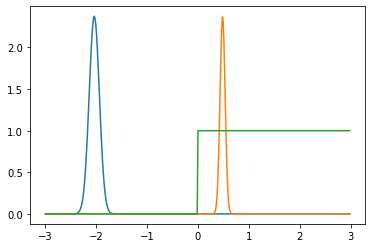

In [5]:
#Different plots to visualize and see the difference between pulses at different z and comparing to a pure gaussian pump.
#plt.plot(zplot,Lambda(zplot,2))
plt.plot(zplot,Lambda2(zplot,0))
plt.plot(zplot,Lambda2(zplot,3))
plt.plot(zplot,np.heaviside(zplot,0))

In [43]:
#Next we try to obtain the same numerical results by Fourier Transforming in k space, evaluating the time evolution, and fourier transforming back in z.
#We do this because when we add the next level of complication we won't have an analytical expression

In [6]:
#Finding fourier transform of pump pulse
FT = np.sum(np.exp(-1j*np.tensordot(k,zplot,axes=0))/np.sqrt(2*np.pi)*dz*Lambda(zplot,0),axis=1)
FT2 = np.sum(np.exp(-1j*np.tensordot(k,zplot,axes=0))/np.sqrt(2*np.pi)*dz*Lambda2(zplot,0),axis=1)

In [7]:
#Defining a function that will hopefully work to evaluate a matrix value by value.
Basic_ft = lambda z,k,func: np.sum(np.exp(-1j*np.tensordot(k,z,axes=0))/np.sqrt(2*np.pi)*(z[1]-z[0])*func,axis=2) #for matrix input
Basic_ft1 = lambda z,k,func: np.sum(np.exp(-1j*np.tensordot(k,z,axes=0))/np.sqrt(2*np.pi)*(z[1]-z[0])*func,axis=1) #for when you want to input a vector and not a matrix
Basic_ift = lambda z,k,func: np.sum(np.exp(1j*np.tensordot(z,k,axes=0))/np.sqrt(2*np.pi)*(k[1]-k[0])*func,axis=1)

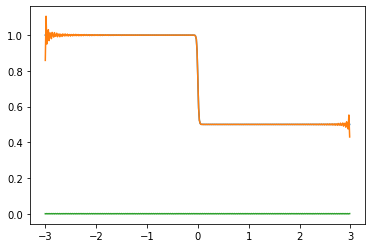

In [8]:
#Velocity in z space
vel = (v1/2)*(1+np.tanh(-k3*zplot))+(v2/2)*(1+np.tanh(k3*zplot))
#Verfication that our momentum and space steps are OK. We want IFT(FT(vel)) to give the same thing back (up to small oscillations/errors) in the range of interest.
#If you get weird plateaus/periodicities,play around with ranges and discretization step.
vel2 = Basic_ift(zplot,k,Basic_ft1(zplot,k,vel))
plt.plot(zplot,vel,zplot,vel2.real,zplot,vel2.imag)


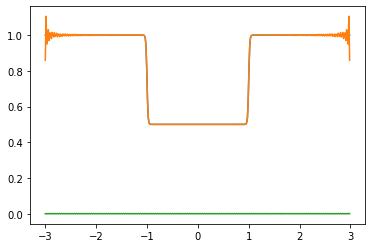

In [9]:
#Here we consider a finitelength crystal that goes from -l to l
vel = v1+((v2-v1)/2)*(1+np.tanh(k3*(zplot+1)))-((v2-v1)/2)*(1+np.tanh(k3*(zplot-1)))
#Verfication that our momentum and space steps are OK. We want IFT(FT(vel)) to give the same thing back (up to small oscillations/errors) in the range of interest.
#If you get weird plateaus/periodicities,play around with ranges and discretization step.
vel2 = Basic_ift(zplot,k,Basic_ft1(zplot,k,vel))
plt.plot(zplot,vel,zplot,vel2.real,zplot,vel2.imag)

In [17]:
v_int = -1j*Basic_ft(zplot,-k+k[:,np.newaxis],vel)@np.diag(k)*dk/np.sqrt(2*np.pi)-1j*(-k+k[:,np.newaxis])*Basic_ft(zplot,-k+k[:,np.newaxis],vel)*dk/np.sqrt(2*np.pi)/2#-1j*0.0005*np.diag(k**2)

In [18]:
Evol= lambda t: expm(v_int*t)@FT2
Evol2 = lambda t: expm(v_int*t)@FT

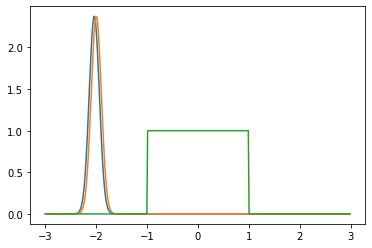

In [19]:
t=0
plt.plot(zplot,np.abs(Basic_ift(zplot,k,Evol(t))))
plt.plot(zplot,np.abs(Basic_ift(zplot,k,Evol2(t))))
plt.plot(zplot,np.heaviside(zplot+1,0)-np.heaviside(zplot-1,0))

In [20]:
time = np.arange(0,6,0.05)
norm=np.zeros_like(time)
norm2=np.zeros_like(time)
i=0
for t in time:
    norm[i] = np.linalg.norm(Basic_ift(zplot,k,Evol(t)))
    norm2[i] = np.linalg.norm(Basic_ift(zplot,k,Evol2(t)))
    i=i+1

In [ ]:
#The rest that follows is for gif making purposes to see the evolution. CHange what you want to plot

In [35]:
def create_frame(t):
    fig, ax1 = plt.subplots()
    ax1.plot(zplot, np.abs(Basic_ift(zplot,k,Evol(t))), label='PumpF') #Here we multiply by a phase factor such that the imaginary part is 0 at the origin.
    ax1.plot(zplot, np.abs(Basic_ift(zplot,k,Evol2(t))), label='PumpF')
    #ax1.plot(zplot, Lambda2(zplot,t).real, label='PumpA')
    #ax1.plot(zplot, Lambda(zplot,t).real, label='PumpG')
    ax1.plot(zplot, np.heaviside(zplot+1,0)-np.heaviside(zplot-1,0), label='Crystal')
    ax1.set_ylim(0, 5)
    ax1.set_xlabel(r"$z$")
    ax1.set_ylabel(r"$Amplitude$")
    ax1.set_title(r"$Blob animation$")
    ax1.legend()
    plt.savefig(f'img_{t}.png', 
                transparent = False,  
                facecolor = 'white'
               )
    plt.close()

In [36]:
time = np.arange(0,6,0.05)
for t in time:
    create_frame(t)

frames = []
for t in time:
    image = imageio.v2.imread(f'img_{t}.png')
    frames.append(image)

imageio.mimsave('example8.gif',frames, duration=100)   